In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  # natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"
import sqlite3

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SOUMYA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
conn = sqlite3.connect(r'../input/amazon-fine-food-reviews/database.sqlite')
conn

query = 'SELECT Score,Summary,Text FROM REVIEWS'
data0 = pd.read_sql_query(query,conn)
data0

OperationalError: unable to open database file

In [3]:
df=data0[['Text']][0:10000]
df

,Text
0,I have bought several of the Vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...
2,This is a confection that has been around a fe...
3,If you are looking for the secret ingredient i...
4,Great taffy at a great price. There was a wid...
...,...
9995,we switched from the advance similac to the or...
9996,"Like the bad reviews say, the organic formula ..."
9997,I wanted to solely breastfeed but was unable t...
9998,i love the fact that i can get this delieved t...


In [4]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

In [5]:
cleantext=[]
for item in tqdm(df['Text']):
    words=tweet_to_words(str(item))
    cleantext+=[words]
df['cleantext']=cleantext
df

100%|██████████| 10000/10000 [01:45<00:00, 94.95it/s]


,Text,cleantext
0,I have bought several of the Vitality canned d...,"[bought, sever, vital, can, dog, food, product..."
1,Product arrived labeled as Jumbo Salted Peanut...,"[product, arriv, label, jumbo, salt, peanut, p..."
2,This is a confection that has been around a fe...,"[confect, around, centuri, light, pillowi, cit..."
3,If you are looking for the secret ingredient i...,"[look, secret, ingredi, robitussin, believ, fo..."
4,Great taffy at a great price. There was a wid...,"[great, taffi, great, price, wide, assort, yum..."
...,...,...
9995,we switched from the advance similac to the or...,"[switch, advanc, similac, organ, product, thin..."
9996,"Like the bad reviews say, the organic formula ...","[like, bad, review, say, organ, formula, const..."
9997,I wanted to solely breastfeed but was unable t...,"[want, sole, breastfe, unabl, keep, supplement..."
9998,i love the fact that i can get this delieved t...,"[love, fact, get, deliev, hous, delievi, charg..."


In [6]:
# Apply data processing to each tweet
# X = list(map(tweet_to_words, df['content']))
# print(X==cleantext) #True

In [7]:
def unlist(list):
    words=''
    for item in list:
        words+=item+' '
    return words

In [8]:
def compute_vader_scores(df, label):
    sid = SentimentIntensityAnalyzer()
    df["vader_neg"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neg"])
    df["vader_neu"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neu"])
    df["vader_pos"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["pos"])
    df["vader_comp"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["compound"])
    df['cleantext2'] = df[label].apply(lambda x: unlist(x))
    return df

In [9]:
df2 = compute_vader_scores(df,'cleantext')
df2

,Text,cleantext,vader_neg,vader_neu,vader_pos,vader_comp,cleantext2
0,I have bought several of the Vitality canned d...,"[bought, sever, vital, can, dog, food, product...",0.000,0.573,0.427,0.9081,bought sever vital can dog food product found ...
1,Product arrived labeled as Jumbo Salted Peanut...,"[product, arriv, label, jumbo, salt, peanut, p...",0.129,0.762,0.110,-0.1027,product arriv label jumbo salt peanut peanut a...
2,This is a confection that has been around a fe...,"[confect, around, centuri, light, pillowi, cit...",0.141,0.636,0.223,0.6249,confect around centuri light pillowi citru gel...
3,If you are looking for the secret ingredient i...,"[look, secret, ingredi, robitussin, believ, fo...",0.000,0.854,0.146,0.4404,look secret ingredi robitussin believ found go...
4,Great taffy at a great price. There was a wid...,"[great, taffi, great, price, wide, assort, yum...",0.000,0.455,0.545,0.9186,great taffi great price wide assort yummi taff...
...,...,...,...,...,...,...,...
9995,we switched from the advance similac to the or...,"[switch, advanc, similac, organ, product, thin...",0.071,0.769,0.160,0.4939,switch advanc similac organ product think woul...
9996,"Like the bad reviews say, the organic formula ...","[like, bad, review, say, organ, formula, const...",0.117,0.695,0.188,0.4215,like bad review say organ formula constip daug...
9997,I wanted to solely breastfeed but was unable t...,"[want, sole, breastfe, unabl, keep, supplement...",0.032,0.837,0.131,0.7506,want sole breastfe unabl keep supplement formu...
9998,i love the fact that i can get this delieved t...,"[love, fact, get, deliev, hous, delievi, charg...",0.096,0.616,0.288,0.5859,love fact get deliev hous delievi charg hard f...


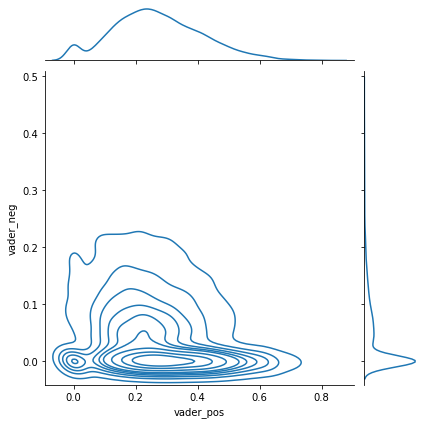

In [10]:
sns.jointplot(data=df2, x='vader_pos', y='vader_neg', kind="kde")

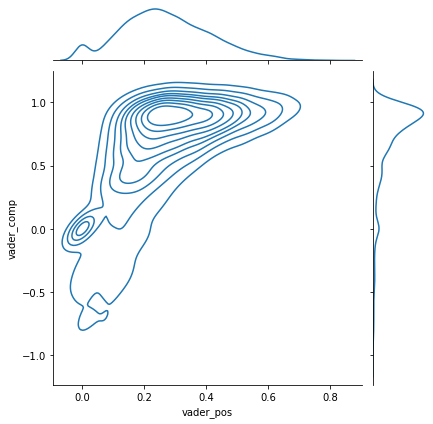

In [11]:
sns.jointplot(data=df2, x='vader_pos', y='vader_comp', kind="kde")

In [12]:
class0=[]
for i in range(len(df2)):
    if df2.loc[i,'vader_neg']>0.06:
        class0+=[0]
    elif df2.loc[i,'vader_pos']>0.3:
        class0+=[2]        
    else:
        class0+=[1]     

In [13]:
print(len(df))
print(len(df2))

10000
10000


In [14]:
df2['class']=class0
df2['class'].value_counts()

1    3885
2    3177
0    2938
Name: class, dtype: int64

# def tokenize_pad_sequences(text):

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=max_len)
    return X, tokenizer

print('Before Tokenization & Padding \n', df['cleantext2'][0])
X, tokenizer = tokenize_pad_sequences(df['cleantext2'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 bought sever vital can dog food product found good qualiti product look like stew process meat smell better labrador finicki appreci product better 
After Tokenization & Padding 
 [  67  207 3306  185   43   16    7   57    6  108    7   48    2 1752
  519  365  172   35 1988  899    7   35    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [16]:
print(X.shape)

(10000, 50)


In [17]:
y = pd.get_dummies(df['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print('Train Set: ', X_train.shape, y_train.shape)
print('Validation Set: ', X_val.shape, y_val.shape)
print('Test Set: ', X_test.shape, y_test.shape)

Train Set:  (6000, 50) (6000, 3)
Validation Set:  (2000, 50) (2000, 3)
Test Set:  (2000, 50) (2000, 3)


In [18]:
import tensorflow.keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses

In [20]:
vocab_size = 5000
embedding_size = 32
epochs = 20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

# Model

In [21]:
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

2021-10-12 09:59:46.348192: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-12 09:59:46.351150: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-12 09:59:46.394936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 09:59:46.395562: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-12 09:59:46.395652: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-12 09:59:46.424521: I tensorflow/stream_executor/platform/def

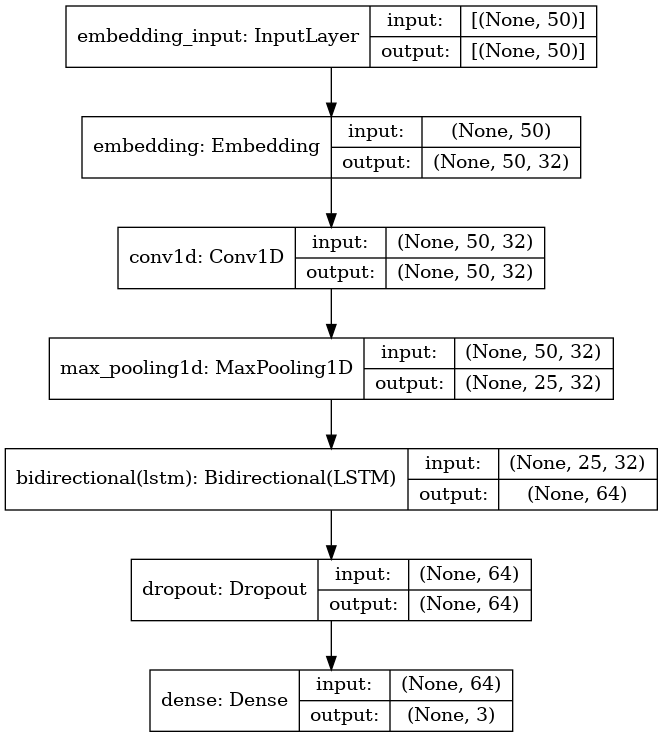

In [22]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [23]:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', Precision(), Recall()])

In [24]:
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),batch_size=64,epochs=epochs,verbose=1)

2021-10-12 09:59:51.186783: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-12 09:59:51.195899: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000175000 Hz


Epoch 1/20


2021-10-12 09:59:54.088346: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-12 09:59:54.919636: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-12 09:59:54.950980: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


94/94 [==============================] - 11s 25ms/step - loss: 1.0856 - accuracy: 0.3942 - precision: 0.5526 - recall: 0.0174 - val_loss: 1.0517 - val_accuracy: 0.4330 - val_precision: 0.5653 - val_recall: 0.1645
Epoch 2/20
94/94 [==============================] - 1s 11ms/step - loss: 1.0517 - accuracy: 0.4416 - precision: 0.5375 - recall: 0.1617 - val_loss: 1.0381 - val_accuracy: 0.4540 - val_precision: 0.5872 - val_recall: 0.1565
Epoch 3/20
94/94 [==============================] - 1s 11ms/step - loss: 1.0394 - accuracy: 0.4564 - precision: 0.5746 - recall: 0.1782 - val_loss: 1.0293 - val_accuracy: 0.4665 - val_precision: 0.5771 - val_recall: 0.2320
Epoch 4/20
94/94 [==============================] - 1s 10ms/step - loss: 1.0344 - accuracy: 0.4595 - precision: 0.5672 - recall: 0.1785 - val_loss: 1.0081 - val_accuracy: 0.4935 - val_precision: 0.6003 - val_recall: 0.2125
Epoch 5/20
94/94 [==============================] - 1s 10ms/step - loss: 1.0093 - accuracy: 0.4962 - precision: 0.5957

# Evaluate

In [25]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)

print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))

Accuracy  : 0.6170
Precision : 0.6605
Recall    : 0.5535
F1 Score  : 0.6023


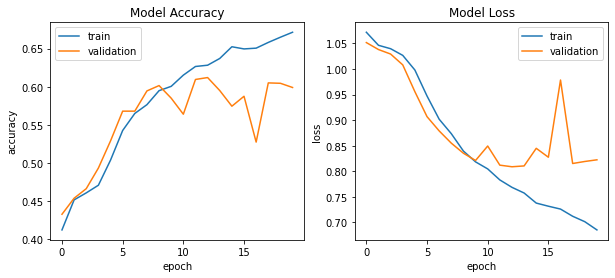

In [26]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

1    751
2    673
0    576
dtype: int64
1    993
2    837
0    170
dtype: int64


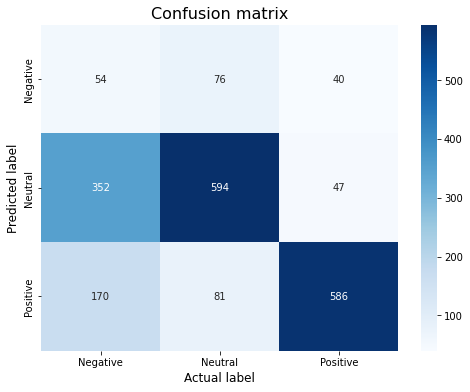

In [27]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes =   ['Negative','Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))

    print(pd.Series(np.argmax(np.array(y_test),axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())
    
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)